# 필수 라이브러리 임포트

In [1]:
!pip install --upgrade joblib==1.1.0
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import mglearn

from sklearn.model_selection import train_test_split 

In [3]:
!apt -qq -y install fonts-nanum > /dev/null

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

sns.set_theme(style="darkgrid")

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=fontpath).get_name() 
fm._rebuild()  


%config InlineBackend.figure_format = 'retina'

plt.rc('font', family=font_name)  
plt.rcParams['axes.unicode_minus'] = False 

# 차원의 저주(The curse of dimensionality)
- 데이터 학습을 위해 차원이 증가하면서 학습데이터 수가 차원의 수보다 적어져 성능이 저하되는 현상
- 차원이 증가할 수록 개별 차원 내 학습할 데이터 수가 적어지는(sparse) 현상 발생  

해결책은 차원을 축소하거나 데이터를 더 많이 수집해야함.

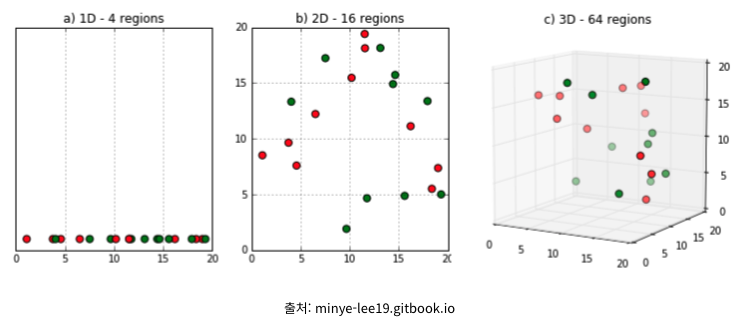

상기 이미지와 같이 데이터양은 동일하지만 차원만 늘어나면 빈공간이 많아지는 것을 볼 수 있다.  
이것은 데이터 상에 0값으로 채워진 부분이 늘어난다는 뜻이다. 따라서 모델이 학습할 때, 상대적으로 데이터가 적어지므로, 성능이 저하될 수 밖에 없다.   

특히 KNN과 같이 특정 알고리즘은 성능저하가 매우 심각해진다.

## KNN을 이용한 예제

In [4]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import OneHotEncoder

In [5]:
X, y = mglearn.datasets.make_forge() 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=0)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


In [6]:
clf = KNeighborsClassifier(n_neighbors=3).fit(X_tr, y_tr)
print(f'훈련용 평가지표: {clf.score(X_tr, y_tr)} / 테스트용 평가지표: {clf.score(X_te, y_te)}')

훈련용 평가지표: 0.9473684210526315 / 테스트용 평가지표: 0.8571428571428571


In [7]:
print(f'before: {X.shape}')
enc = OneHotEncoder()
X_enc = enc.fit_transform(X)
print(f'after: {X_enc.shape}')

before: (26, 2)
after: (26, 52)


In [8]:
X_tr_enc, X_te_enc, y_tr, y_te = train_test_split(X_enc, y, random_state=0)

In [9]:
clf = KNeighborsClassifier(n_neighbors=3).fit(X_tr_enc, y_tr)
print(f'훈련용 평가지표: {clf.score(X_tr_enc, y_tr)} / 테스트용 평가지표: {clf.score(X_te_enc, y_te)}')

훈련용 평가지표: 0.9473684210526315 / 테스트용 평가지표: 0.42857142857142855


상기 결과를 보듯이 차원이 너무 많은 경우, 오버피팅이 발생하여 테스트용 평가지표가 매우 낮게 나타난 것을 확인할 수 있었다.

# 데이터 로드

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

SEED = 42

In [11]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [12]:
DATA_PATH = "/content/data/MyDrive/lecture/data/"
df = pd.read_csv(DATA_PATH+"Titanic.csv")

df.columns = [col.lower() for col in df.columns] # 컬럼명 소문자로 변환
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [13]:
y_train = df["survived"] # 정답값
df = df.drop('survived', axis=1) # 정답값 제외
df.shape, y_train.shape

((891, 11), (891,))

In [14]:
# 결측치 미리 채우기
df.age = df.age.fillna(df.age.median()) # age 중앙값
df.fare = df.fare.fillna(df.fare.median()) # fare 중앙값
df.cabin = df.cabin.fillna("UNK") # cabin 임의의 문자열로 채우기
df.embarked = df.embarked.fillna(df.embarked.mode()[0]) # embarked 최빈값

In [15]:
# 학습에 바로 사용가능한 특성
cols = ["pclass","age","sibsp","parch","fare"]
features = df[cols]

In [16]:
print(f'before: {df.shape}')
# 범주형 one-hot encoding
cols = ["sex","embarked","ticket","cabin"]
enc = OneHotEncoder()
sparse_features = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
x_train = pd.concat([features,sparse_features],axis=1) # 특성
print(f'after: {x_train.shape}')
x_train.head()

before: (891, 11)
after: (891, 839)


,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,...,cabin_F E69,cabin_F G63,cabin_F G73,cabin_F2,cabin_F33,cabin_F38,cabin_F4,cabin_G6,cabin_T,cabin_UNK
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Base model

In [17]:
model = LGBMClassifier(random_state=SEED)
cv = KFold(n_splits=5,shuffle=True,random_state=SEED)

scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
base_score = scores.mean()
base_score

0.8733600217740358

# 주성분 분석(PCA; Principal component Analysis)
> 특성들이 통계적으로 상관관계가 없도록 데이터셋을 회전시키는 기술입니다. 회전한 뒤에 데이터를 설명하는 데 얼마나 중요하냐에 따라 종종 새로운 특성 중 일부만 선택됩니다.  

- 주요 파라미터
  - n_components: 주성분의 수

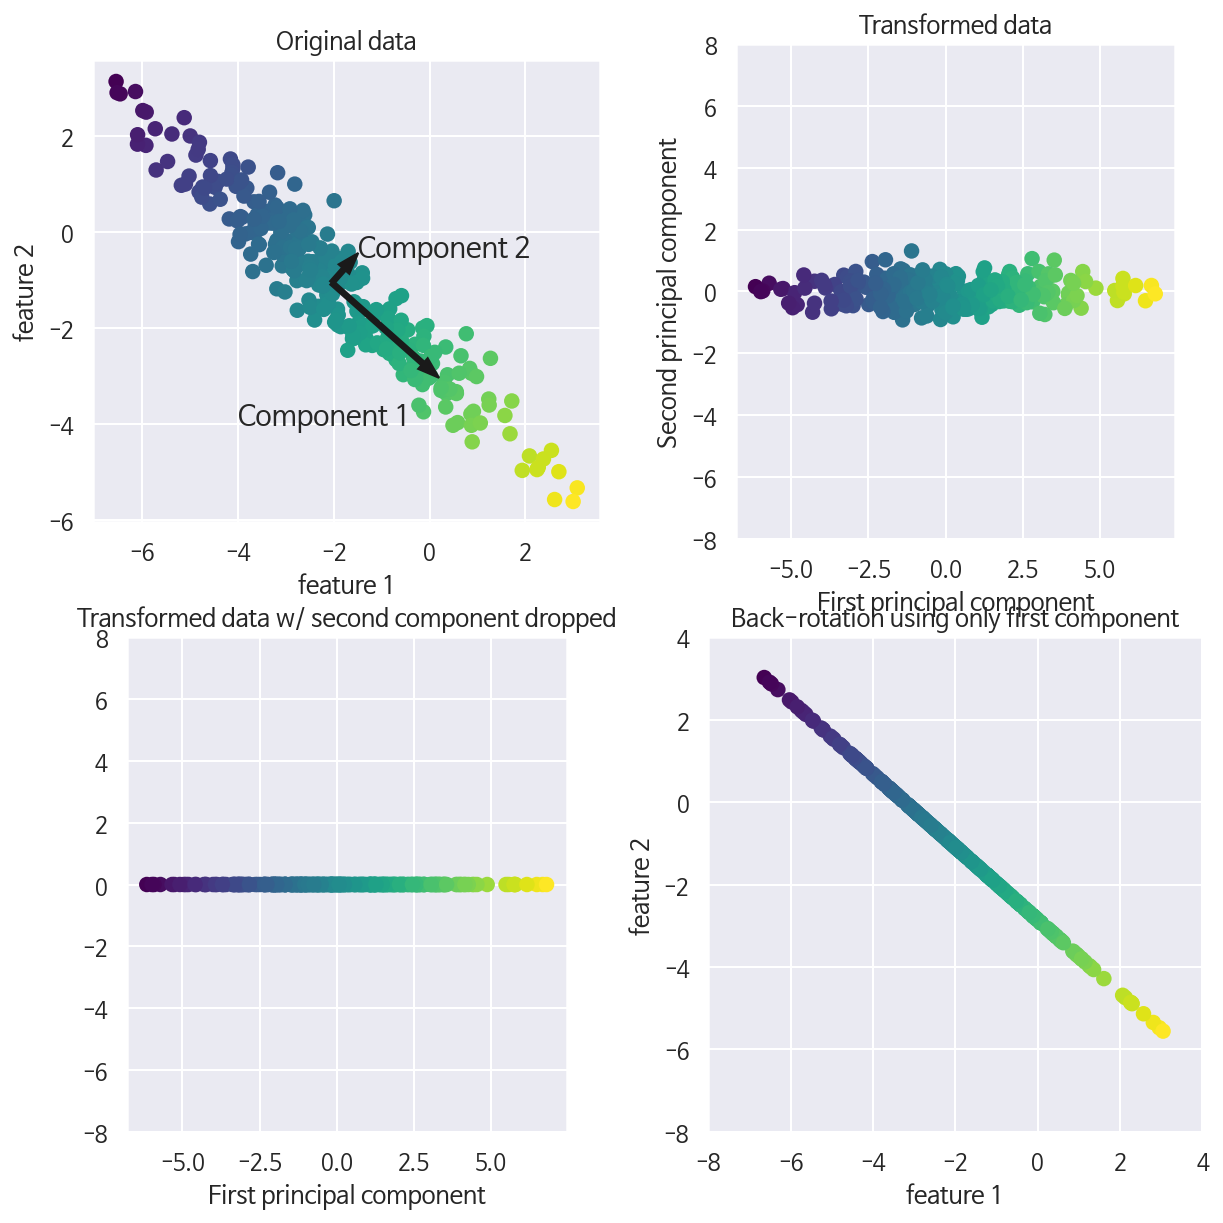

In [18]:
mglearn.plots.plot_pca_illustration()

## Base model과 비교

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components=sparse_features.shape[1],random_state = SEED)
pca.fit(sparse_features)
sum(pca.explained_variance_ratio_)

1.0000000000000222

In [21]:
tmp = pd.DataFrame(pca.transform(sparse_features)).add_prefix("pca_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 839)


In [22]:
model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.8848592006690342 / base_score: 0.8733600217740358


주성분 200인 경우

In [23]:
pca200 = PCA(n_components=200,random_state=SEED)
pca200.fit(sparse_features)
# 주성분에 의해 설명되는 분산비율
sum(pca200.explained_variance_ratio_)

0.7444941408409604

In [24]:
tmp = pd.DataFrame(pca200.transform(sparse_features)).add_prefix("pca_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 205)


In [25]:
model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.8784533367540897 / base_score: 0.8733600217740358


주성분 400인 경우

In [26]:
pca400 = PCA(n_components=400,random_state=SEED)
pca400.fit(sparse_features)
# 주성분에 의해 설명되는 분산비율
sum(pca400.explained_variance_ratio_)

0.8514220959331704

In [27]:
tmp = pd.DataFrame(pca400.transform(sparse_features)).add_prefix("pca_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 405)


In [28]:
model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.8829561378800251 / base_score: 0.8733600217740358


839개 피처를 사용한 base_score보다 405개 피처만 사용한 PCA가 적용된 score가 성능이 좋게 나왔다.

# 특이값 분해(SVD; Singular Value Decomposition)

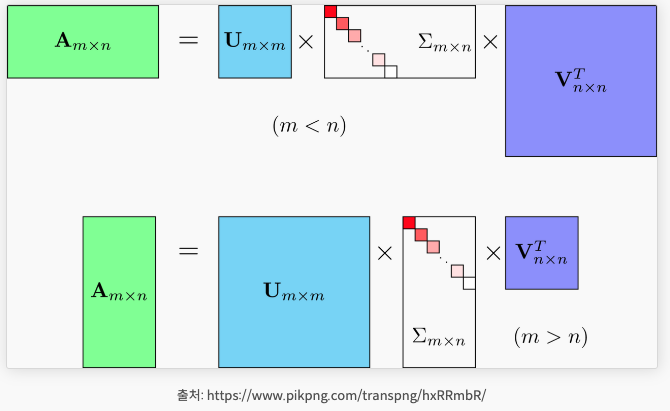

m x n 크기의 행렬 A는 m x m 크기의 형렬 U와 m x n 크기의 $\sum$ 그리고 n x n 크기의 $V^T$(행렬 V의 전치행렬)로 나뉩니다.  
이렇게 행렬 A를 분해하는 것을 특이값 분해라고 한다. 

## 특이값 분해 및 복원 실습

In [29]:
np.random.seed(121)
# 4x4 행렬 a 생성
a = np.random.randn(4,4)
np.round(a,3)

array([[-0.212, -0.285, -0.574, -0.44 ],
       [-0.33 ,  1.184,  1.615,  0.367],
       [-0.014,  0.63 ,  1.71 , -1.327],
       [ 0.402, -0.191,  1.404, -1.969]])

특이값 분해

In [30]:
from numpy.linalg import svd

U, Sigma, Vt = svd(a) # 특이값 분행

print(U.shape, Sigma.shape, Vt.shape)
print('U matrix:\n',np.round(U, 3))
print('Sigma Value:\n',np.round(Sigma, 3))
print('V transpose matrix:\n',np.round(Vt, 3))

(4, 4) (4,) (4, 4)
U matrix:
 [[-0.079 -0.318  0.867  0.376]
 [ 0.383  0.787  0.12   0.469]
 [ 0.656  0.022  0.357 -0.664]
 [ 0.645 -0.529 -0.328  0.444]]
Sigma Value:
 [3.423 2.023 0.463 0.079]
V transpose matrix:
 [[ 0.041  0.224  0.786 -0.574]
 [-0.2    0.562  0.37   0.712]
 [-0.778  0.395 -0.333 -0.357]
 [-0.593 -0.692  0.366  0.189]]


복원

In [39]:
# Sima를 다시 0 을 포함한 대칭행렬로 변환
Sigma_mat = np.diag(Sigma)
a_ = np.dot(np.dot(U, Sigma_mat), Vt)
print(f'원본: {np.round(a,3)}')
print('-'*50)
print(f'복원: {np.round(a_, 3)}')

원본: [[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.014  0.63   1.71  -1.327]
 [ 0.402 -0.191  1.404 -1.969]]
--------------------------------------------------
복원: [[-0.212 -0.285 -0.574 -0.44 ]
 [-0.33   1.184  1.615  0.367]
 [-0.014  0.63   1.71  -1.327]
 [ 0.402 -0.191  1.404 -1.969]]


> 기존 a행렬과 값이 같은 것을 확인할 수 있다.

## Base model과 비교

In [32]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100,random_state=SEED)
svd.fit(sparse_features)
sum(svd.explained_variance_ratio_)

0.6467003948429446

In [33]:
tmp = pd.DataFrame(svd.transform(sparse_features)).add_prefix("svd_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 105)


In [34]:
model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.8893929682055424 / base_score: 0.8733600217740358


# 비음수 행렬 분해(NMF; Non-negative Matrix Factorization)
> 비음수 행렬 인수분해라고 불리는 이유는 음수가 아닌 특성과 가중치를 반환하기 때문이다.  

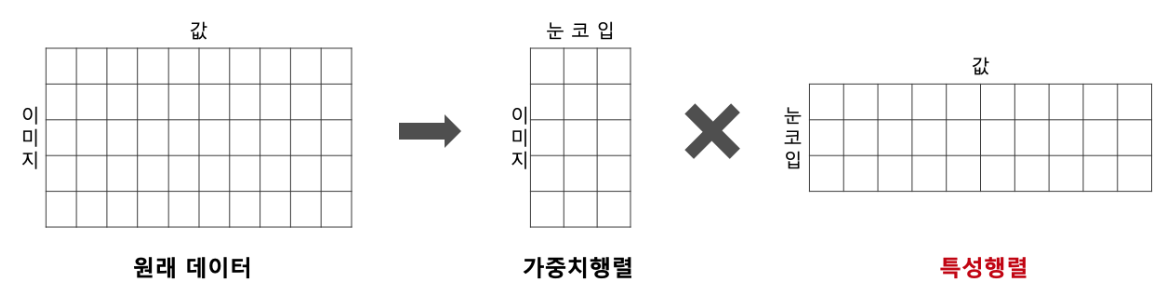

## Base model과 비교

In [35]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=100,random_state=SEED,max_iter=500)
nmf.fit(sparse_features)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


NMF(max_iter=500, n_components=100, random_state=42)

In [36]:
(nmf.components_ < 0).sum(), nmf.components_.shape

(0, (100, 834))

In [37]:
tmp = pd.DataFrame(nmf.transform(sparse_features)).add_prefix("nmf_")
x_train = pd.concat([features,tmp],axis=1)
print(f'after: {x_train.shape}')

after: (891, 105)


In [38]:
model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.8634616181361162 / base_score: 0.8733600217740358
